<font size="+3"><strong>3. Gradient Boosting Trees</strong></font>

In [1]:
# Import libraries
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler

from ipywidgets import interact
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from IPython.display import display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score

# Prepare Data

## Import

In [2]:
filepath = "Bank Marketing/Bankdata.csv"

def wrangle(filepath):
    """
    Wrangles the  data by:
    1. Reading the CSV file.
    2. Dropping the 'Unnamed: 0' column.
    3. Encoding the target variable 'y' to 0 and 1.
    4. Selecting only numeric data features.

    Parameters:
    filepath (str): Path to the CSV file.

    Returns:
    pd.DataFrame: Cleaned and wrangled DataFrame.
    """
    # Read the CSV file
    df = pd.read_csv(filepath)

    # Drop unnecessary column 'Unnamed: 0'
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)

    # Encode target variable 'y' to 0 and 1
    if 'y' in df.columns:
        df['y'] = df['y'].map({'yes': 1, 'no': 0})

    # Select only numeric data features
    df = df.select_dtypes(include='number')

    # Print DataFrame type and shape
    print("df type:", type(df))
    print("df shape:", df.shape)

    return df

In [3]:
df = wrangle("Bankdata.csv")
df.head()

df type: <class 'pandas.core.frame.DataFrame'>
df shape: (86399, 6)


,age,duration,campaign,pdays,previous,y
0,58,261,1,-1,0,0
1,44,151,1,-1,0,0
2,33,76,1,-1,0,0
3,47,92,1,-1,0,0
4,33,198,1,-1,0,0


## Split

Create your feature matrix `X` and target vector `Y`. The target is `"y"`.

In [4]:
target = "y"
X = df.drop(columns=target)
Y = df[target]

print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (86399, 5)
Y shape: (86399,)


Divide your data (`X` and `y`) into training and test sets using a randomized train-test split. Your test set should be 20% of your total data. Set a `random_state` for reproducibility. 

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state = 42)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (69119, 5)
Y_train shape: (69119,)
X_test shape: (17280, 5)
Y_test shape: (17280,)


## Resample

Create a new feature matrix `X_train_over` and target vector `Y_train_over` by performing random over-sampling on the training data.

In [6]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, Y_train_over = over_sampler.fit_resample(X_train, Y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head(2)

X_train_over shape: (122340, 5)


,age,duration,campaign,pdays,previous
0,53,160,1,-1,0
1,24,297,1,323,2


# Build Model

Calculate the baseline accuracy score for the model.

In [7]:
acc_baseline = Y_train.value_counts(normalize =True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.885


## Iterate

 Create a pipeline named `clf` (short for "classifier") that contains a `SimpleImputer` transformer and a `GradientBoostingClassifier` predictor.

In [8]:
clf = make_pipeline(SimpleImputer(), GradientBoostingClassifier()) 

Considering the *positive* class. Here, the positive class is the one where the clients opted for `bank term deposit accounts`. The positive class is made up of the clients with the `y: yes` key-value pair.

### hyperparameters for the model

Create a dictionary with the range of hyperparameters that we want to evaluate for the classifier.

In [9]:
params = {"simpleimputer__strategy": ["mean","median"],
          "gradientboostingclassifier__n_estimators": range (20, 31, 5),
         "gradientboostingclassifier__max_depth": range(2, 5)}
         
params

{'simpleimputer__strategy': ['mean', 'median'],
 'gradientboostingclassifier__n_estimators': range(20, 31, 5),
 'gradientboostingclassifier__max_depth': range(2, 5)}

Smaller numbers of `n_estimators` are considered because `GradientBoostingClassifier` is slower to train than the `RandomForestClassifier`.

Create a `GridSearchCV` named `model` that includes your classifier and hyperparameter grid. Be sure to use the same arguments for `cv` and `n_jobs` that you used above, and set `verbose` to 1.

In [10]:
model = GridSearchCV(clf,  param_grid=params, cv=5, n_jobs=-1, verbose=1)

#### Fitting the model 

Fit your `model` to the over-sampled training data.

In [11]:
params = {"simpleimputer__strategy": ["mean","median"],
          "gradientboostingclassifier__n_estimators": range (20, 31, 5),
         "gradientboostingclassifier__max_depth": range(2, 5)}

model = GridSearchCV(clf,  param_grid=params, cv=5, n_jobs=-1, verbose=1)


# Fit model to over-sampled training data
model.fit(X_train_over, Y_train_over)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

Extract the cross-validation results from `model` and load them into a DataFrame named `cv_results`.

In [12]:
results = pd.DataFrame(model.cv_results_)
results.sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
17,9.333157,0.403086,0.073205,0.007243,4,30,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.798471,0.799902,0.797286,0.801782,0.799248,0.799338,0.001501,1
16,9.543994,0.084879,0.079226,0.006995,4,30,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.798471,0.799902,0.797286,0.801782,0.799248,0.799338,0.001501,1
15,8.082841,0.057090,0.070751,0.003416,4,25,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.798717,0.799125,0.796346,0.800678,0.798063,0.798586,0.001413,3
14,7.962597,0.078964,0.069807,0.002009,4,25,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.798717,0.799125,0.796346,0.800678,0.798063,0.798586,0.001413,3
13,6.531894,0.028018,0.061987,0.003376,4,20,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.796837,0.797082,0.793567,0.797572,0.797818,0.796575,0.001543,5


Extract the best hyperparameters from `model`.

In [13]:
# Extract best hyperparameters
model.best_params_

{'gradientboostingclassifier__max_depth': 4,
 'gradientboostingclassifier__n_estimators': 30,
 'simpleimputer__strategy': 'mean'}

## Evaluate

Calculate the training and test accuracy scores for `model`. 

In [14]:
acc_train = model.score(X_train, Y_train)
acc_test = model.score(X_test, Y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Validation Accuracy:", round(acc_test, 4))

Training Accuracy: 0.8106
Validation Accuracy: 0.8058


Plot a confusion matrix that shows how your best model performs on your test set.

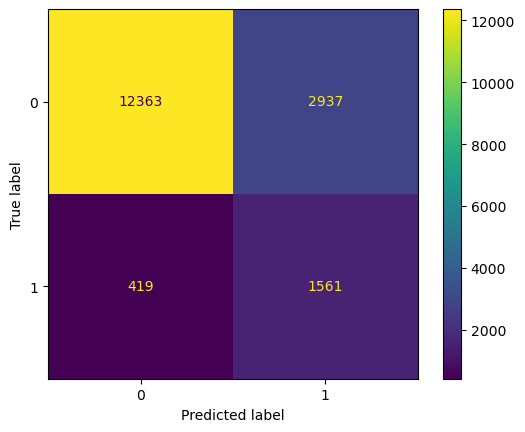

In [15]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test);

Print the classification report for the model, using the test set.

In [16]:
# Print classification report
print(classification_report(Y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.81      0.88     15300
           1       0.35      0.79      0.48      1980

    accuracy                           0.81     17280
   macro avg       0.66      0.80      0.68     17280
weighted avg       0.90      0.81      0.83     17280



Since we're trying to maximize our profit (bank gains), the *quality* of our predictions is much more important than the *quantity* of our predictions.

### Precision Score

Precision is the fraction of true positives over all positive predictions. It is a measure of how "precise" our model is with regard to labeling observations as positive. 

In this scenario, we try to predict whether a client will subscribe a term deposit with the bank, with `"yes"` as the positive class. Out of all positive predictions made by the model, some clients actually subscribed for a bank term deposit (True Positive `TP`), while others didn't (False Positive `FP`). Precision measures how many times model predicted positives (`TP`+`FP`) correctly (`TP`).  The equation for precision is: 
$$ \text{precision} = \frac{\text{TP}}{TP + FP}$$

Precision: Measures how many of the predicted `yes` were actually **`yes.`**

### Recall Score

What if we care more about the model performance in the negative class? In this case, we need to calculate **recall**. Recall the fraction of true positives over all positive observations. It is a measure of our model's ability to "catch" and properly label observations that are positive. *(measures how well the model identifies observations that belong to the positive class)*

Consider [Polish Companies Bankruptcy](https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data). Of all the companies that actually went bankrupt (`TP`+`FN`), how many companies did the model predict as going bankrupt (`TP`)? That's what recall measures. The equation to calculate recall is:

$$ \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}. $$

Recall: Measures how well the model captures all the actual `yes` cases.

In [17]:
# Generate predicted probabilities (requires a probabilistic model like GradientBoosting)
y_probs = model.predict_proba(X_test)[:, 1]  # Probability of positive class

# Create widgets
threshold_slider = widgets.FloatSlider(
    value=0.5, # Default threshold
    min=0,     # Minimum threshold value
    max=1,     # Maximum threshold value
    step=0.01, # Step size for the slider
    description='Threshold:',
    style={'description_width': 'initial'}
)

# Output area for plot and metrics
out = widgets.Output()

# Function to update confusion matrix and metrics
def update_confusion_matrix(threshold):
    # Convert probabilities to binary predictions using threshold
    y_pred = (y_probs >= threshold).astype(int)
    
    # Compute metrics
    cm = confusion_matrix(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred)
    accuracy = accuracy_score(Y_test, y_pred)
    
    # Clear previous output and plot
    with out:
        out.clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(6, 6))
        ConfusionMatrixDisplay(cm).plot(ax=ax)
        plt.title(f"Confusion Matrix (Threshold = {threshold:.2f})\n"
                  f"Precision = {precision:.2f}, Recall = {recall:.2f}, Accuracy = {accuracy:.2f}")
        plt.show()

# Link slider to update function
interactive_plot = widgets.interactive(update_confusion_matrix, threshold=threshold_slider)

# Display widgets and initial plot
display(threshold_slider, out)
update_confusion_matrix(threshold_slider.value)

FloatSlider(value=0.5, description='Threshold:', max=1.0, step=0.01, style=SliderStyle(description_width='init…

Output()

In [18]:
model.predict(X_test)[:10]

array([1, 0, 0, 1, 0, 0, 0, 1, 1, 0], dtype=int64)

In [19]:
model.predict_proba(X_test)[:10, -1]

array([0.82295363, 0.08281801, 0.3258324 , 0.83921713, 0.37552607,
       0.18945915, 0.13861188, 0.83033556, 0.85648394, 0.24494305])

*Threshold = 0.50*. If the model value > 0.5, it is registered as a **`yes`** and if the model value < 0.5, it implies that the model predicted a **`no`**.

### Business Implications

- **Goal 1: Maximize Customer Acquisition**  
  - Prioritize high recall for `yes` **(79% is decent).**
  - **Cost:** Many false positives **(65% of `yes` predictions are incorrect)**. Marketing teams might waste effort on uninterested customers.  
  - The bank should opt to obtain atleast two phone contacts & an email address of all the customers it receives.

- **Goal 2: Minimize Wasted Resources**  
  - Prioritize high precision for `yes` **(35% is very poor).** 
  - **Cost:** Miss 21% of actual `yes` customers (lower acquisition).
  - Develop new products that increase customer loyalty through CSR activities.  
  - Obtain feedback from clients through customer surveys. 

- **Threshold Adjustment:**  
  - To reduce false positives (improve precision), increase the classification threshold (e.g., only predict `yes` with confidence level greater than 80%). This would lower recall but improve precision.  As threshold goes down, Recall goes up, meaning a lower threshold is more likely to predict a positive class i.e. a client will subscribe a bank term deposit. When threshold = 0, the model obtains perfect recall because it is predicting that all clients in the test set will apply for a term deposit. 

<center>
<table>
  <tr>
    <th>Date (YYYY-MM-DD)</th>
    <th>Author</th>
  </tr>
  <tr>
    <td>2025-02-23</td>
    <td>Andrew Kalumba Harris</td>
    <td>andrewkalumbaharris@gmail.com</td>
  </tr>
</table>
</center>
